In [2]:
import sys
#add directory to path to allow importing of modules if not already in path
if "/home/d.gaillard/source/NIPTov-analysis-tools" not in sys.path:
    sys.path.append("/home/d.gaillard/source/NIPTov-analysis-tools")


import WCR_analysis_tools
from importlib import reload
reload(WCR_analysis_tools)
from WCR_analysis_tools import *

In [3]:
# get cpa and clinical data
# load CPA per case
import pandas as pd
from pathlib import Path
def get_CPA_from_wiseX(list_of_statfiles):
    """
    Function to extract CPA scores from statistics text files from WISECONDORX outputs
    """

    ids = [statfile.stem.split('_')[0] for statfile in list_of_statfiles]
    cpa_scores = []
    for statfile in list_of_statfiles:
        with open(statfile) as f:
            last_line = f.readlines()[-1]
            cpa_score = float(last_line.split(':')[-1].replace('\n', ''))
            cpa_scores.append(cpa_score)

    df = pd.DataFrame(
        {
            'PGDXID': ids,
            'cpa_score_PE': cpa_scores
        }).set_index('PGDXID')

    return df

base_path = Path('/home/d.gaillard/paired_ovarian/snakemake-wisecondorx-loocv/output_folder/outfiles')

list_of_statfiles = list(base_path.joinpath('benign').glob("*looref_statistics.txt"))
cpa_benign = get_CPA_from_wiseX(list_of_statfiles)


list_of_statfiles = list(base_path.joinpath('malignant').glob("*ref_benign_statistics.txt"))
cpa_malignant = get_CPA_from_wiseX(list_of_statfiles)

cpa_benign['label'] = 0
cpa_malignant['label'] = 1
cpa_df = pd.concat([cpa_malignant,cpa_benign]).reset_index()

# load HE4 and RMI
import numpy as np
dfclin = pd.read_spss("/home/d.gaillard/paired_ovarian/clinical_data/NIPT-clinical_he4_data.sav")
dfclin.rename(columns={'Barcode' : 'barcode'}, inplace=True)
dfclin.rename(columns={'Studienummer' : 'studienummer'}, inplace=True)

dfclin = dfclin.loc[:, ['studienummer','barcode','HE4', 'RMI']]
dfclin['log_HE4'] = np.log(dfclin['HE4'] + 1)
dfclin['log_RMI'] = np.log(dfclin['RMI'] + 1)
dfclin['studienummer'] = dfclin['studienummer'].astype('int').astype('str')

# labels df
labels = pd.read_csv('/home/d.gaillard/paired_ovarian/label_data/labels.csv', dtype="string")
labels.rename(columns={'Patient_ID_1' : 'studienummer'}, inplace=True)

# merge clin df, labels and paired-CPA
df = pd.merge(dfclin, labels, on='studienummer')
df = pd.merge(df, cpa_df, on='PGDXID')

# combine with SE results
SE_results = pd.read_csv('/home/d.gaillard/paired_ovarian/single_end_results/cpa_per_case_SE.csv')
SE_results.rename(columns={"cpa_score" : "cpa_score_SE"}, inplace=True)
df = pd.merge(df, SE_results, on='barcode', suffixes=['_df', '_SE'])
df = df.fillna(df.mean())
df['log_cpa_score_PE'] = np.log(df['cpa_score_PE'])
df['log_cpa_score_SE'] = np.log(df['cpa_score_SE'])

df_previous_results = df.copy()

/tmp/ipykernel_3776051/2829393036.py:62: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df.fillna(df.mean())


In [4]:
from pathlib import Path
base = Path('/home/d.gaillard/paired_ovarian/fragment_lengh_distibution/delfi_ratios')


# get label data
label_df = pd.read_csv('/home/d.gaillard/paired_ovarian/label_data/labels.csv')
label_df = label_df.set_index('PGDXID')
labels = label_df.loc[:, 'Lesion_Type']
data = {}

for file in base.glob('*b250000_*.csv'):
    # get label
    PGDXID = file.stem.split('_')[0]
    lab = labels.loc[PGDXID]
    data[PGDXID] = {'label': lab}

    # read file
    df = pd.read_csv(file, sep='\t')
    data[PGDXID]['df'] = df
    

In [5]:
## get processed data

for PGDXID in data.keys():
    lab = data[PGDXID]['label']

    # create new df
    df = data[PGDXID]['df']
    df = df.loc[df['contig'] != 'chrY', :]
    
    # determine path to cnv file based on label and PGDXID
    if lab.lower() == 'malignant':
        cnv_file = f'/home/d.gaillard/paired_ovarian/snakemake-wisecondorx-loocv/output_folder/outfiles/malignant/{PGDXID}_WGS_hg19_mrk_ref_benign_bins.bed'
    elif lab.lower() == 'benign':
        cnv_file = f'/home/d.gaillard/paired_ovarian/snakemake-wisecondorx-loocv/output_folder/outfiles/benign/{PGDXID}_WGS_hg19_mrk_looref_bins.bed'
    df_cnv = pd.read_csv(cnv_file, sep='\t')

    assert len(df) == len(df_cnv), f'length of df and df_cnv do not match for {PGDXID}, {len(df)} vs {len(df_cnv)}'
    
    # add variables using .loc indexer
    df.loc[:, 'cnv_ratio'] = df_cnv.loc[:, 'ratio'].values
    df.loc[:, 'cnv_zscore'] = df_cnv.loc[:, 'zscore'].values

    # perform division with check for invalid values
    mask = df.loc[:, 'long_reads'].values != 0
    df.loc[mask, 'delfi_score'] = df.loc[mask, 'short_reads'].values / df.loc[mask, 'long_reads'].values
    df.loc[~mask, 'delfi_score'] = np.nan


    # add df2 to processed_data
    data[PGDXID]['df'] = df


/tmp/ipykernel_3776051/1971447126.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'cnv_ratio'] = df_cnv.loc[:, 'ratio'].values
/tmp/ipykernel_3776051/1971447126.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'cnv_zscore'] = df_cnv.loc[:, 'zscore'].values
/tmp/ipykernel_3776051/1971447126.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

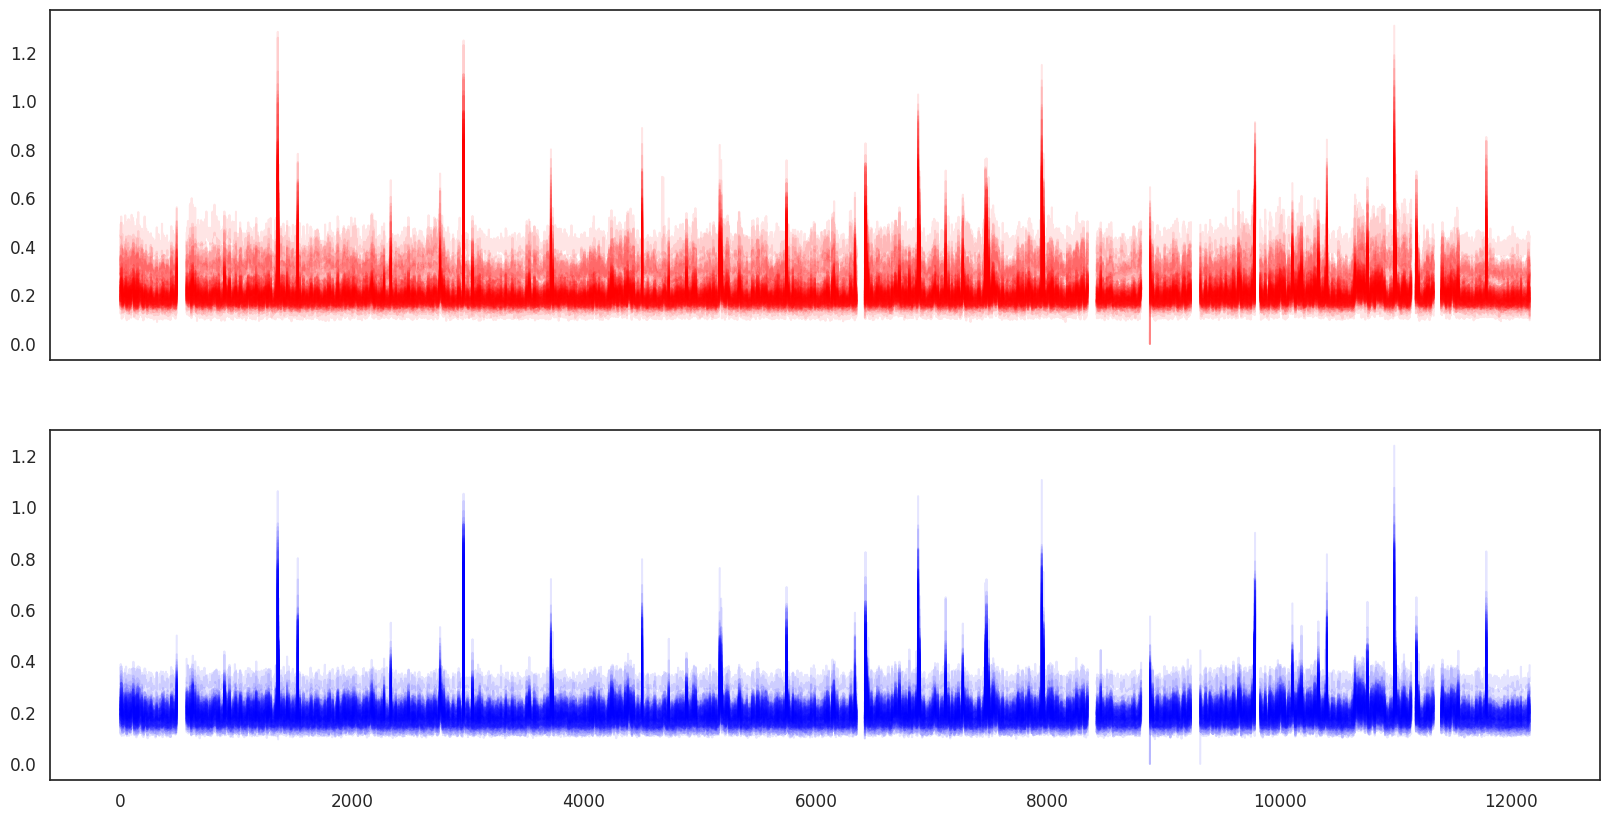

In [6]:
# plot delfi score for each PGDXID over all bins, plotting malignant in red and benign in blue
# plot 2 wide plots underneith each other with the same x axis (all bins). the top are the malignant and bottom the benign
fig, axs = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
for PGDXID in data.keys():
    df = data[PGDXID]['df']
    lab = data[PGDXID]['label']
    if lab.lower() == 'malignant':
        color = 'red'
        axs[0].plot(df['delfi_score'], color=color, alpha=0.1)
    elif lab.lower() == 'benign':
        color = 'blue'
        axs[1].plot(df['delfi_score'], color=color, alpha=0.1)

plt.show()        

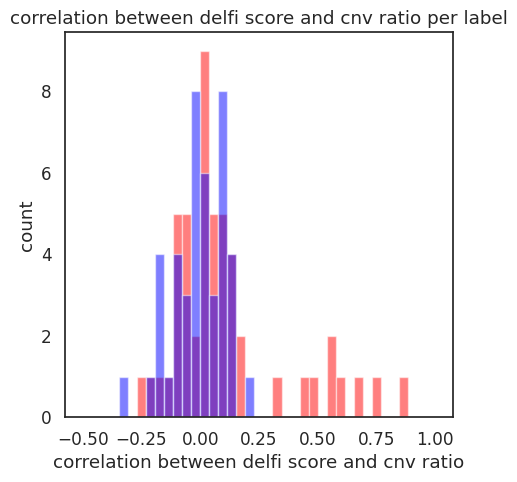

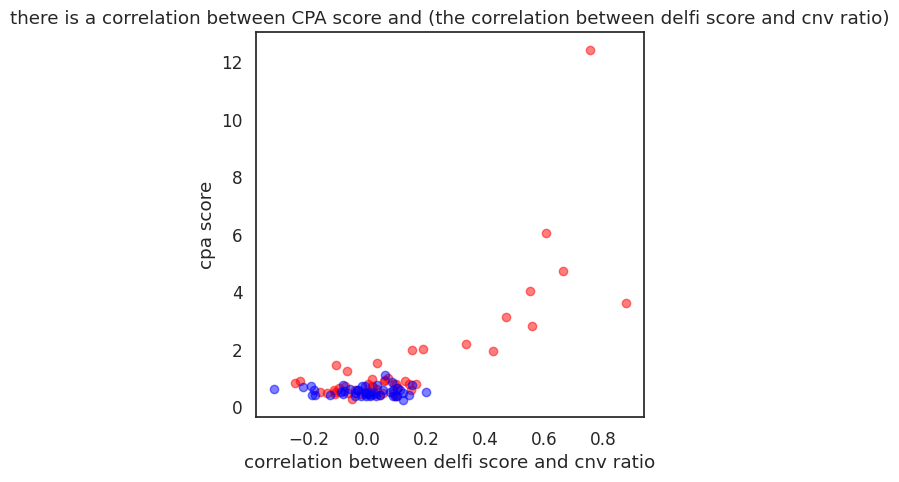

In [7]:
# calculate correlation of delfi score and cnv ratio for each PGDXID
for PGDXID in data.keys():
    corr = data[PGDXID]['df'][['delfi_score', 'cnv_ratio']].corr().values[0, 1]
    data[PGDXID]['corr'] = corr

# plot correlations per label
corr_malignant = [data[PGDXID]['corr'] for PGDXID in data.keys() if data[PGDXID]['label'].lower() == 'malignant']
corr_benign = [data[PGDXID]['corr'] for PGDXID in data.keys() if data[PGDXID]['label'].lower() == 'benign']

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
bins = np.linspace(-.5, 1, 40)
ax.hist(corr_malignant, bins=bins, color='red', alpha=0.5, label='malignant')
ax.hist(corr_benign, bins=bins, color='blue', alpha=0.5, label='benign')
# add axis labels and title
ax.set_xlabel('correlation between delfi score and cnv ratio')
ax.set_ylabel('count')
ax.set_title('correlation between delfi score and cnv ratio per label')
plt.show()

# list the top 15 PGDXIDs with the highest correlation and their label
corr_sorted = sorted([(PGDXID, data[PGDXID]['corr'], data[PGDXID]['label']) for PGDXID in data.keys()], key=lambda x: x[1], reverse=True)
corr_sorted[:15]

# now plot a scatterplot with correlation between delfi score and cnv ratio on the x axis and the cpa score on the y axis, color malignant red and benign blue
# set CPA per case
for PGDXID in data.keys():
    # get CPA score from df_previous_results where PGDXID matches
    cpa_score = df_previous_results.loc[df_previous_results['PGDXID'] == PGDXID, 'cpa_score_PE'].values[0]
    data[PGDXID]['cpa_score'] = cpa_score
    
# plot scatterplot
cpa_scores_benign = [data[PGDXID]['cpa_score'] for PGDXID in data.keys() if data[PGDXID]['label'].lower() == 'benign']
cpa_scores_malignant = [data[PGDXID]['cpa_score'] for PGDXID in data.keys() if data[PGDXID]['label'].lower() == 'malignant']
corr_malignant = [data[PGDXID]['corr'] for PGDXID in data.keys() if data[PGDXID]['label'].lower() == 'malignant']
corr_benign = [data[PGDXID]['corr'] for PGDXID in data.keys() if data[PGDXID]['label'].lower() == 'benign']

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(corr_malignant, cpa_scores_malignant, color='red', alpha=0.5, label='malignant')
ax.scatter(corr_benign, cpa_scores_benign, color='blue', alpha=0.5, label='benign')
# add axis labels and title
ax.set_xlabel('correlation between delfi score and cnv ratio')
ax.set_ylabel('cpa score')
ax.set_title('there is a correlation between CPA score and (the correlation between delfi score and cnv ratio)')
plt.show()

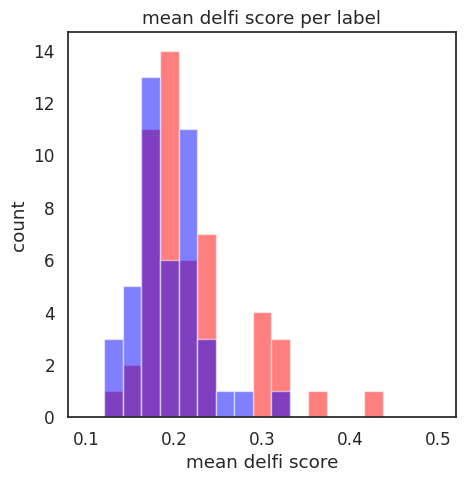

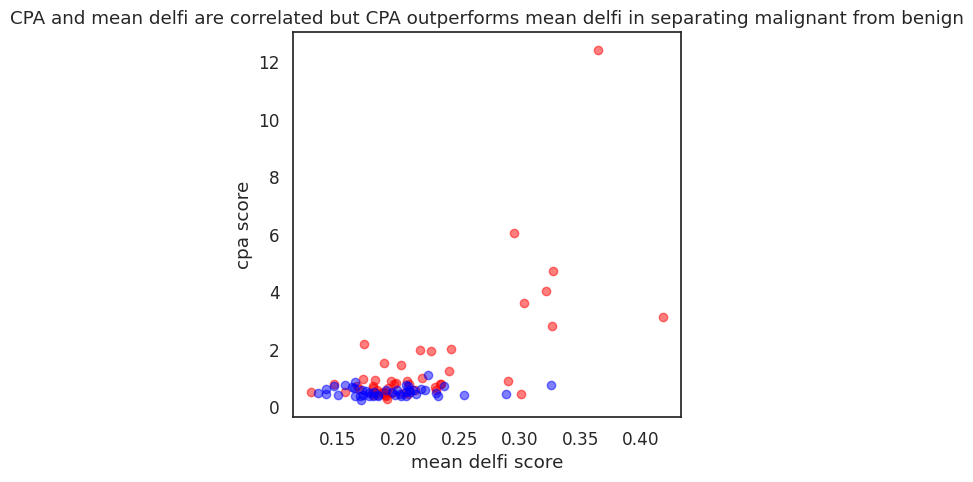

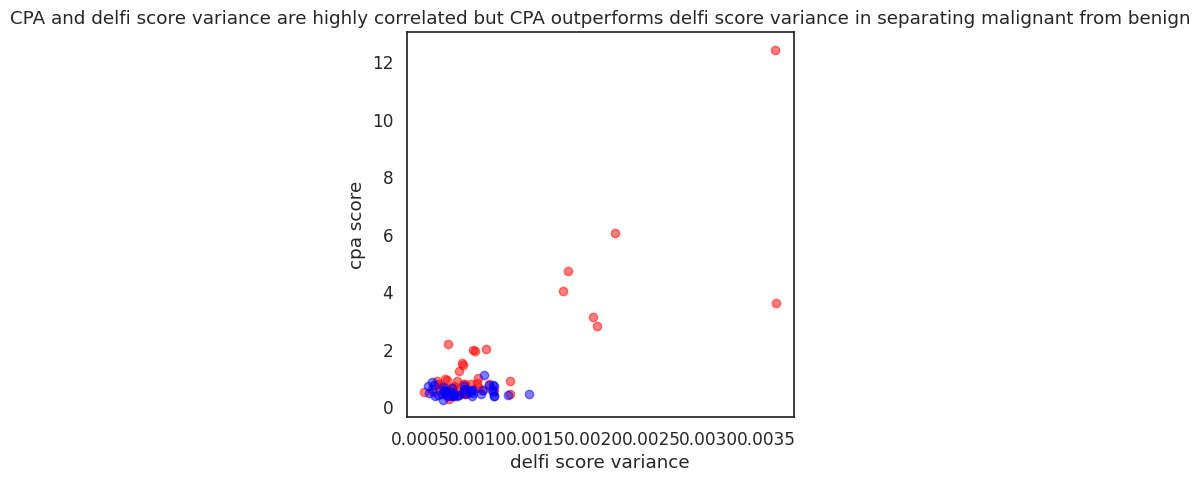

In [15]:
# get the mean delfi score for each PGDXID
for PGDXID in data.keys():
    df = data[PGDXID]['df']
    data[PGDXID]['mean_delfi_score'] = df['delfi_score'].mean()

# plot the mean delfi score for each PGDXID in a histogram, color malignant red and benign blue
mean_delfi_scores_benign = [data[PGDXID]['mean_delfi_score'] for PGDXID in data.keys() if data[PGDXID]['label'].lower() == 'benign']
mean_delfi_scores_malignant = [data[PGDXID]['mean_delfi_score'] for PGDXID in data.keys() if data[PGDXID]['label'].lower() == 'malignant']

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

bins = np.linspace(0.1, 0.5, 20)
ax.hist(mean_delfi_scores_malignant, bins=bins, color='red', alpha=0.5, label='malignant')
ax.hist(mean_delfi_scores_benign, bins=bins, color='blue', alpha=0.5, label='benign')
# add axis labels and title
ax.set_xlabel('mean delfi score')
ax.set_ylabel('count')
ax.set_title('mean delfi score per label')
plt.show()

# create scatterplot of mean delfi score and cpa score, color malignant red and benign blue
mean_delfi_scores_benign = [data[PGDXID]['mean_delfi_score'] for PGDXID in data.keys() if data[PGDXID]['label'].lower() == 'benign']
mean_delfi_scores_malignant = [data[PGDXID]['mean_delfi_score'] for PGDXID in data.keys() if data[PGDXID]['label'].lower() == 'malignant']
cpa_scores_benign = [data[PGDXID]['cpa_score'] for PGDXID in data.keys() if data[PGDXID]['label'].lower() == 'benign']
cpa_scores_malignant = [data[PGDXID]['cpa_score'] for PGDXID in data.keys() if data[PGDXID]['label'].lower() == 'malignant']

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(mean_delfi_scores_malignant, cpa_scores_malignant, color='red', alpha=0.5, label='malignant')
ax.scatter(mean_delfi_scores_benign, cpa_scores_benign, color='blue', alpha=0.5, label='benign')
# add axis labels and title
ax.set_xlabel('mean delfi score')
ax.set_ylabel('cpa score')
ax.set_title('CPA and mean delfi are correlated but CPA outperforms mean delfi in separating malignant from benign')
plt.show()

# now create a scatterplot of delfi score variance and cpa score, color malignant red and benign blue
delfi_score_variances_benign = [data[PGDXID]['df']['delfi_score'].var() for PGDXID in data.keys() if data[PGDXID]['label'].lower() == 'benign']
delfi_score_variances_malignant = [data[PGDXID]['df']['delfi_score'].var() for PGDXID in data.keys() if data[PGDXID]['label'].lower() == 'malignant']

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(delfi_score_variances_malignant, cpa_scores_malignant, color='red', alpha=0.5, label='malignant')
ax.scatter(delfi_score_variances_benign, cpa_scores_benign, color='blue', alpha=0.5, label='benign')
# add axis labels and title
ax.set_xlabel('delfi score variance')
ax.set_ylabel('cpa score')
ax.set_title('CPA and delfi score variance are highly correlated but CPA outperforms delfi score variance in separating malignant from benign')
plt.show()


/tmp/ipykernel_3776051/3453406348.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'delfi_score'] = df.loc[mask, 'short_reads'].values / df.loc[mask, 'long_reads'].values
/tmp/ipykernel_3776051/3453406348.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'delfi_score'] = df.loc[mask, 'short_reads'].values / df.loc[mask, 'long_reads'].values
/tmp/ipykernel_3776051/3453406348.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

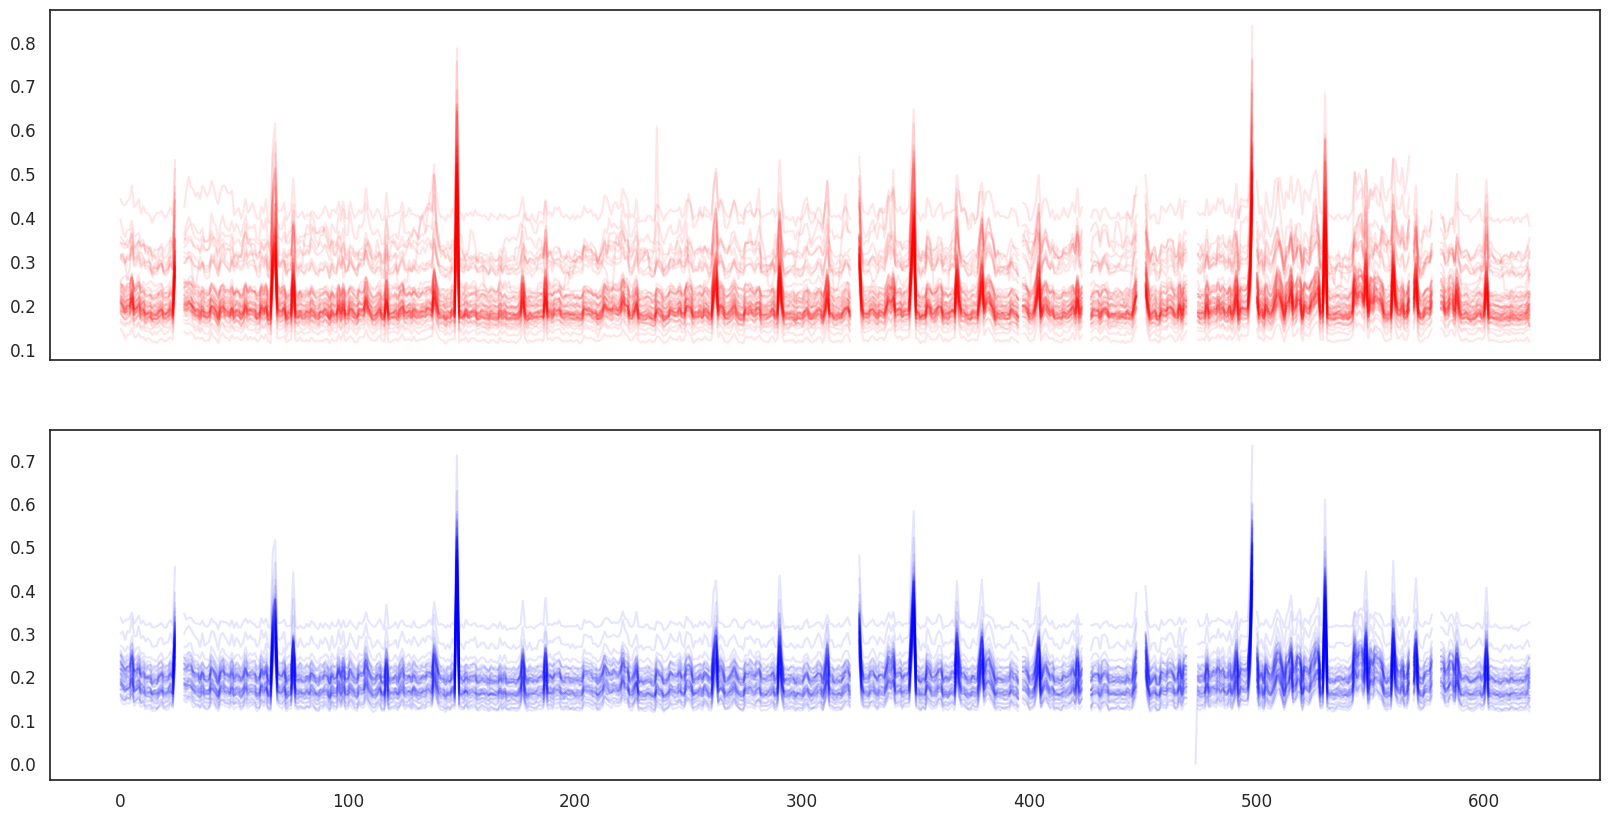

In [16]:
# do the same for binsize 5_000_000

# recreate data dict
from pathlib import Path
base = Path('/home/d.gaillard/paired_ovarian/fragment_lengh_distibution/delfi_ratios')


# get label data
label_df = pd.read_csv('/home/d.gaillard/paired_ovarian/label_data/labels.csv')
label_df = label_df.set_index('PGDXID')
labels = label_df.loc[:, 'Lesion_Type']
data = {}

for file in base.glob('*b5000000_*.csv'):
    # get label
    PGDXID = file.stem.split('_')[0]
    lab = labels.loc[PGDXID]
    data[PGDXID] = {'label': lab}

    # read file
    df = pd.read_csv(file, sep='\t')
    data[PGDXID]['df'] = df
    

for PGDXID in data.keys():
    lab = data[PGDXID]['label']

    # create new df
    df = data[PGDXID]['df']
    df = df.loc[df['contig'] != 'chrY', :]

    # perform division with check for invalid values
    mask = df.loc[:, 'long_reads'].values != 0
    df.loc[mask, 'delfi_score'] = df.loc[mask, 'short_reads'].values / df.loc[mask, 'long_reads'].values
    df.loc[~mask, 'delfi_score'] = np.nan

    # add df2 to processed_data
    data[PGDXID]['df'] = df


# plot data
# plot delfi score for each PGDXID over all bins, plotting malignant in red and benign in blue
# plot 2 wide plots underneith each other with the same x axis (all bins). the top are the malignant and bottom the benign
fig, axs = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
for PGDXID in data.keys():
    df = data[PGDXID]['df']
    lab = data[PGDXID]['label']
    if lab.lower() == 'malignant':
        color = 'red'
        axs[0].plot(df['delfi_score'], color=color, alpha=0.1)
    elif lab.lower() == 'benign':
        color = 'blue'
        axs[1].plot(df['delfi_score'], color=color, alpha=0.1)

plt.show()        



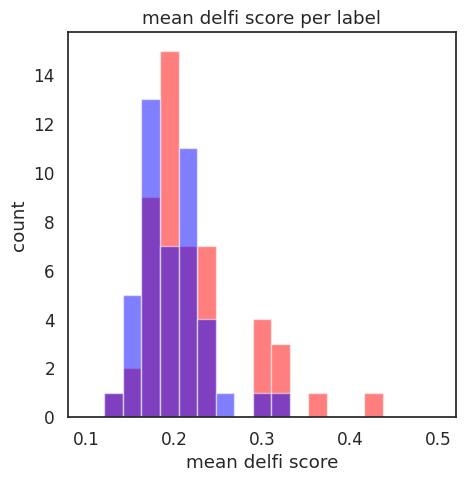

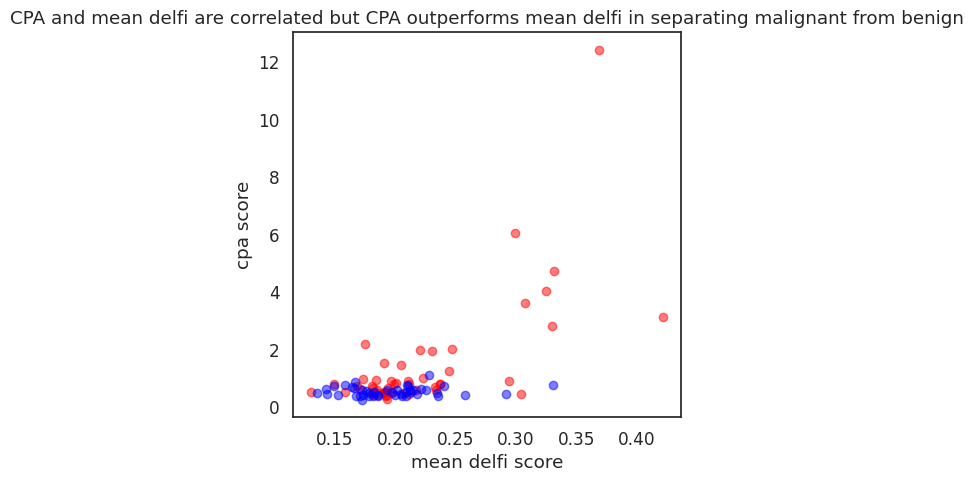

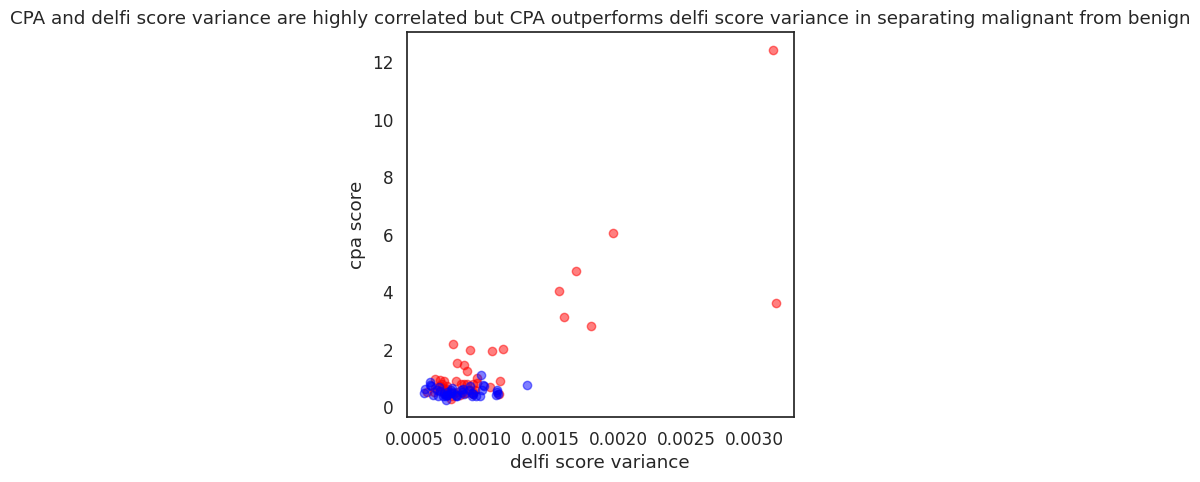

In [18]:
# get the mean delfi score for each PGDXID
for PGDXID in data.keys():
    df = data[PGDXID]['df']
    data[PGDXID]['mean_delfi_score'] = df['delfi_score'].mean()

for PGDXID in data.keys():
    # get CPA score from df_previous_results where PGDXID matches
    cpa_score = df_previous_results.loc[df_previous_results['PGDXID'] == PGDXID, 'cpa_score_PE'].values[0]
    data[PGDXID]['cpa_score'] = cpa_score

    
# plot the mean delfi score for each PGDXID in a histogram, color malignant red and benign blue
mean_delfi_scores_benign = [data[PGDXID]['mean_delfi_score'] for PGDXID in data.keys() if data[PGDXID]['label'].lower() == 'benign']
mean_delfi_scores_malignant = [data[PGDXID]['mean_delfi_score'] for PGDXID in data.keys() if data[PGDXID]['label'].lower() == 'malignant']

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

bins = np.linspace(0.1, 0.5, 20)
ax.hist(mean_delfi_scores_malignant, bins=bins, color='red', alpha=0.5, label='malignant')
ax.hist(mean_delfi_scores_benign, bins=bins, color='blue', alpha=0.5, label='benign')
# add axis labels and title
ax.set_xlabel('mean delfi score')
ax.set_ylabel('count')
ax.set_title('mean delfi score per label')
plt.show()

# create scatterplot of mean delfi score and cpa score, color malignant red and benign blue
mean_delfi_scores_benign = [data[PGDXID]['mean_delfi_score'] for PGDXID in data.keys() if data[PGDXID]['label'].lower() == 'benign']
mean_delfi_scores_malignant = [data[PGDXID]['mean_delfi_score'] for PGDXID in data.keys() if data[PGDXID]['label'].lower() == 'malignant']
cpa_scores_benign = [data[PGDXID]['cpa_score'] for PGDXID in data.keys() if data[PGDXID]['label'].lower() == 'benign']
cpa_scores_malignant = [data[PGDXID]['cpa_score'] for PGDXID in data.keys() if data[PGDXID]['label'].lower() == 'malignant']

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(mean_delfi_scores_malignant, cpa_scores_malignant, color='red', alpha=0.5, label='malignant')
ax.scatter(mean_delfi_scores_benign, cpa_scores_benign, color='blue', alpha=0.5, label='benign')
# add axis labels and title
ax.set_xlabel('mean delfi score')
ax.set_ylabel('cpa score')
ax.set_title('CPA and mean delfi are correlated but CPA outperforms mean delfi in separating malignant from benign')
plt.show()

# now create a scatterplot of delfi score variance and cpa score, color malignant red and benign blue
delfi_score_variances_benign = [data[PGDXID]['df']['delfi_score'].var() for PGDXID in data.keys() if data[PGDXID]['label'].lower() == 'benign']
delfi_score_variances_malignant = [data[PGDXID]['df']['delfi_score'].var() for PGDXID in data.keys() if data[PGDXID]['label'].lower() == 'malignant']

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(delfi_score_variances_malignant, cpa_scores_malignant, color='red', alpha=0.5, label='malignant')
ax.scatter(delfi_score_variances_benign, cpa_scores_benign, color='blue', alpha=0.5, label='benign')
# add axis labels and title
ax.set_xlabel('delfi score variance')
ax.set_ylabel('cpa score')
ax.set_title('CPA and delfi score variance are highly correlated but CPA outperforms delfi score variance in separating malignant from benign')
plt.show()


# models dont rerun

In [79]:
# now, we train a a elastic net model on the delfi scores to predict malignant or benign
# we use the delfi scores for the 5_000_000 bins for this

delfi_scores = []
indexes = []
labels = []

for PGDXID in data.keys():
    df = data[PGDXID]['df']
    delfi = df['delfi_score'].values
    delfi_scores.append(delfi)
    indexes.append(PGDXID)
    labels.append(data[PGDXID]['label'])
    
df_elastic = pd.DataFrame(delfi_scores, index=indexes)

# map labels to 0 and 1
labels = np.array([0 if lab.lower() == 'benign' else 1 for lab in labels])

# count the number of columns with a nan value
print('number of columns with a nan value: {}'.format(df_elastic.isna().any().sum()))

# get mask of where nans are
mask = df_elastic.isna().any()

# print mean number of nans per column if col has nans
print('mean number of nans per column if col has nans: {}'.format(df_elastic.loc[:, mask].isna().sum().mean()))

# drop columns with nans
df_elastic = df_elastic.loc[:, ~mask]

# print number of columns left
print('number of columns left: {}'.format(df_elastic.shape[1]))


# define X and y
X = df_elastic.values
y = np.array(labels)

# define double nested cross validation scheme for hyperparameter tuning
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, LeaveOneOut
from sklearn.linear_model import ElasticNet, LogisticRegression

# define outer and inner cv
outer_cv = LeaveOneOut()
inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# define parameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],  # alpha is the regularization parameter
                'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}  # l1_ratio is the ratio between l1 and l2 regularization

# define gridsearch
grid = GridSearchCV(LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000), param_grid=param_grid, cv=inner_cv, scoring='accuracy', n_jobs=24)

# perform double nested cross validation
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report

# define lists to store results
labels = []
preds = []
probas = []
best_params = []

# perform double nested cross validation

for train_index, test_index in outer_cv.split(X, y):
    # split data
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # store labels
    labels.append(y_test)

    # perform gridsearch
    grid.fit(X_train, y_train)

    # get best params
    best_params.append(grid.best_params_)

    # get best model
    model = grid.best_estimator_

    # get predictions and probabilities
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # store predictions and probabilities
    preds.append(y_pred)
    probas.append(y_proba)

    # get accuracy scores, draw confusion matrix and print best params for each fold
    print('accuracy score for fold: {}'.format(accuracy_score(y_test, y_pred)))
    print('best params for fold: {}'.format(grid.best_params_))
    print('confusion matrix for fold: \n{}'.format(confusion_matrix(y_test, y_pred)))


number of columns with a nan value: 22
mean number of nans per column if col has nans: 97.95454545454545
number of columns left: 599


accuracy score for fold: 0.0
best params for fold: {'C': 10, 'l1_ratio': 0.9}
confusion matrix for fold: 
[[0 1]
 [0 0]]
accuracy score for fold: 1.0
best params for fold: {'C': 100, 'l1_ratio': 0.1}
confusion matrix for fold: 
[[1]]
accuracy score for fold: 0.0
best params for fold: {'C': 1, 'l1_ratio': 0.1}
confusion matrix for fold: 
[[0 1]
 [0 0]]
accuracy score for fold: 1.0
best params for fold: {'C': 1, 'l1_ratio': 0.1}
confusion matrix for fold: 
[[1]]
accuracy score for fold: 1.0
best params for fold: {'C': 1, 'l1_ratio': 0.3}
confusion matrix for fold: 
[[1]]
accuracy score for fold: 1.0
best params for fold: {'C': 1, 'l1_ratio': 0.3}
confusion matrix for fold: 
[[1]]
accuracy score for fold: 1.0
best params for fold: {'C': 1, 'l1_ratio': 0.3}
confusion matrix for fold: 
[[1]]
accuracy score for fold: 0.0
best params for fold: {'C': 1, 'l1_ratio': 0.1}
confusion matrix for fold: 
[[0 1]
 [0 0]]
accuracy score for fold: 1.0
best params for fold: {'C': 1, 'l1_ratio': 0.3}
confu

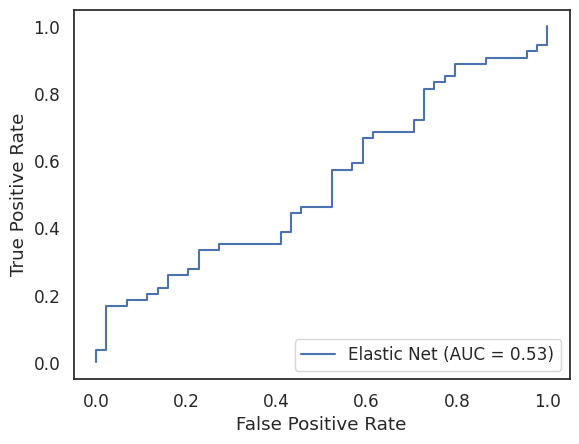

In [80]:
from sklearn.metrics import accuracy_score, roc_curve, RocCurveDisplay
labels = np.concatenate(labels)
probas = np.concatenate(probas)

fpr, tpr, thresholds = roc_curve(labels, probas)
roc_auc = roc_auc_score(labels, probas)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Elastic Net')
roc_display.plot()

In [49]:
# plot roc curve
fig, ax = plt.subplots(figsize=(10, 10))


Int64Index([ 25,  26,  27, 322, 323, 324, 396, 424, 425, 426, 448, 449, 450,
            470, 471, 472, 473, 499, 568, 578, 579, 580],
           dtype='int64')